In [38]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [6]:
sns.set_theme()

In [7]:
trips19 = pd.read_csv('tripdata_2019-05.csv')
trips20 = pd.read_csv('tripdata_2020-05.csv')

/home/khodor/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Посмотрим, какие пропущенные значения есть в данных.

In [8]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

VendorID 0
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
RatecodeID 0
store_and_fwd_flag 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


In [9]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

VendorID 58891
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
RatecodeID 58891
store_and_fwd_flag 58891
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [10]:
max_passengers_count = trips20['passenger_count'].value_counts().idxmax()
print("Max passengers count = ", max_passengers_count)
trips20.passenger_count = trips20.passenger_count.fillna(max_passengers_count)

Max passengers count =  1.0


Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

Преобразуем формат ячеек с временем для удобства.

In [11]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца.

In [12]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [13]:
MILES_TO_KM = 1609.34

trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['average_velocity'] = (trips19['trip_distance'] * MILES_TO_KM) / trips19['trip_duration_secs']

trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['average_velocity'] = (trips20['trip_distance'] * MILES_TO_KM) / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 162 км/ч(45 м/с) сверху и 2(м/с) снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [14]:
trips19 = trips19[trips19.average_velocity <= 45]
trips19 = trips19[trips19.average_velocity > 2]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]

trips20 = trips20[trips20.average_velocity <= 45]
trips20 = trips20[trips20.average_velocity > 2]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]

In [27]:
trips19.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,...,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7.087834e+06,7087834,7.087834e+06,7.087834e+06
mean,1.642229e+00,1.573175e+00,3.164835e+00,1.044347e+00,1.631989e+02,1.613953e+02,1.277424e+00,1.347944e+01,1.190395e+00,4.981835e-01,...,2.999715e-01,1.962876e+01,2.298583e+00,1.543966e+01,3.013124e+00,1.398681e+01,1.402358e+01,0 days 00:14:58.455726,8.984557e+02,5.189487e+00
std,5.020127e-01,1.223310e+00,4.011718e+00,5.135127e-01,6.639744e+01,7.068064e+01,4.624262e-01,1.204027e+01,1.279358e+00,3.019000e-02,...,2.923152e-03,1.493016e+01,6.804088e-01,8.939889e+00,1.857198e+00,6.093660e+00,6.186673e+00,0 days 00:12:34.903679,7.549037e+02,2.703840e+00
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:01,1.000000e+00,2.000008e+00
25%,1.000000e+00,1.000000e+00,1.030000e+00,1.000000e+00,1.160000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,...,3.000000e-01,1.130000e+01,2.500000e+00,8.000000e+00,2.000000e+00,1.000000e+01,1.000000e+01,0 days 00:06:47,4.070000e+02,3.386534e+00
50%,2.000000e+00,1.000000e+00,1.730000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,...,3.000000e-01,1.480000e+01,2.500000e+00,1.500000e+01,3.000000e+00,1.500000e+01,1.500000e+01,0 days 00:11:20,6.800000e+02,4.493081e+00
75%,2.000000e+00,2.000000e+00,3.230000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.500000e+01,2.500000e+00,5.000000e-01,...,3.000000e-01,2.130000e+01,2.500000e+00,2.300000e+01,4.000000e+00,1.900000e+01,1.900000e+01,0 days 00:18:49,1.129000e+03,6.115492e+00
max,4.000000e+00,9.000000e+00,2.632100e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,4.016500e+03,2.300000e+01,3.300000e+00,...,3.000000e-01,4.020300e+03,2.750000e+00,3.100000e+01,6.000000e+00,2.300000e+01,2.300000e+01,0 days 06:26:33,2.319300e+04,4.499230e+01


### Вот тут ниже надо будет графики в один ряд нарисовать.

In [13]:
#xparam = 'week_day'
#yparam = 'total_amount'

#pl19 = sns.relplot(
#    data=trips19, x=xparam, y=yparam,
#)
#pl20 = sns.relplot(
#    data=trips20, x=xparam, y=yparam,
#)

#x_lim = max(trips19[xparam].max(), trips20[xparam].max())
#y_lim = max(trips19[yparam].max(), trips20[yparam].max())
#pl19.set(xticks=(0, x_lim), yticks=(0, y_lim))
#pl20.set(xticks=(0, x_lim), yticks=(0, y_lim))

In [76]:
# зададим размер графиков
plt.rcParams['figure.dpi'] = 90

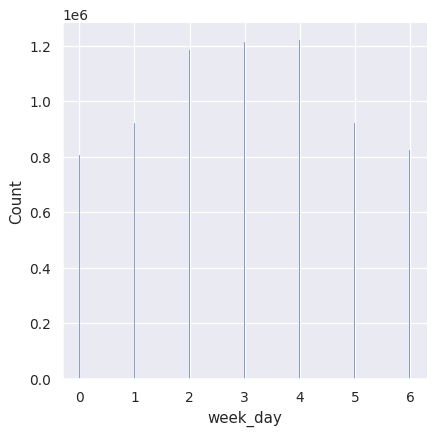

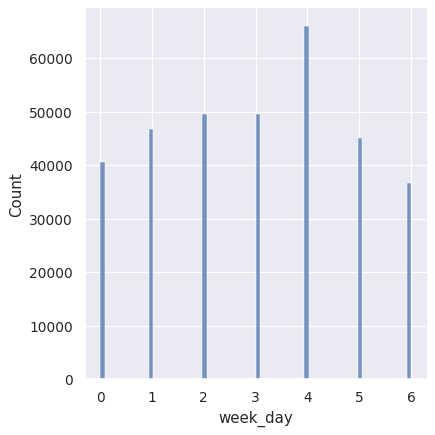

In [75]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

Посмотрим на распределение по времени начала поездки.

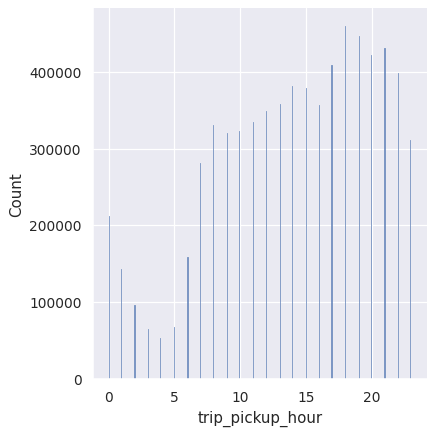

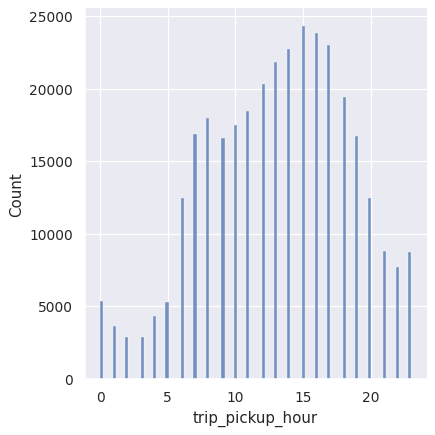

In [36]:
sns.displot(trips19.trip_pickup_hour)
sns.displot(trips20.trip_pickup_hour)

По дате начала поездки.

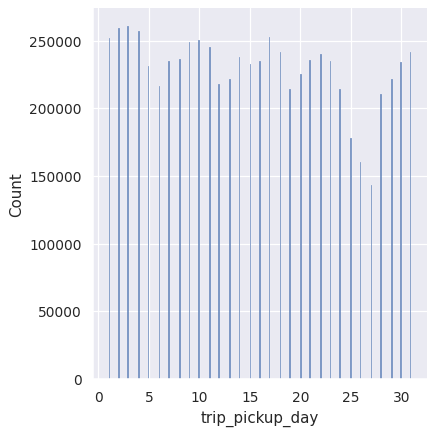

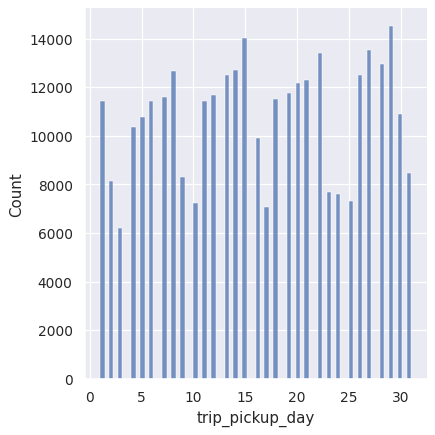

In [37]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

Тут блок про то, как я доставал эти бл*дские координаты.

### Отметим все выезды на карте.

Импортируем данные о точках в каждой PUDLocation.

In [48]:
taxi_zones = pd.read_csv('taxi_zones.csv')

Добавим в таблицы с данными о поездках координаты посадки и высадки пассажиров. 

In [ ]:
#trips19['pickup_location'] = 
#trips20['pickup_location'] = 

#trips19['dropoff_location'] = 
#trips20['dropoff_location'] = 

In [73]:
nymap = folium.Map(location=(40.15, -74), zoom_start=10)

In [74]:
loc = [[(40, -74), (40.12, -74.01)], [(40.3, -74.01), (40.2, -74.21)]]

folium.PolyLine(locations=loc).add_to(nymap)

nymap